In [22]:
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import torch
import torch.nn as nn
import yaml
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook as tqdm

sys.path.append("../input/modules")
from utils.utils import read_hdf5
from models.cnn import Cnn14_DecisionLevelAtt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
train_tp = pd.read_csv('../input/rfcx-species-audio-detection/train_tp.csv')
train_fp = pd.read_csv('../input/rfcx-species-audio-detection/train_fp.csv')
tmp = pd.DataFrame(train_tp["recording_id"].value_counts()).reset_index().rename(columns={'index': 'recording_id', "recording_id": "count"})
train_tp["t_diff"] = train_tp["t_max"] - train_tp["t_min"]
train_tp["f_diff"] = train_tp["f_max"] - train_tp["f_min"]
train_fp["t_diff"] = train_fp["t_max"] - train_fp["t_min"]
train_fp["f_diff"] = train_fp["f_max"] - train_fp["f_min"]
train_tp = pd.merge(train_tp, tmp, on="recording_id", how='inner')
train_tp["count"].value_counts()

1    1065
2     110
3      24
4      12
5       5
Name: count, dtype: int64

In [15]:
tmp = pd.DataFrame(train_fp["recording_id"].value_counts()).reset_index().rename(columns={'index': 'recording_id', "recording_id": "count"})
train_fp = pd.merge(train_fp, tmp, on="recording_id", how='inner')
train_fp["count"].value_counts()

1     2028
2     1716
3     1635
4     1356
5      575
6      294
7      126
8       32
10      10
9        9
Name: count, dtype: int64

In [ ]:
train_path_list = os.listdir("../input/rfcx-species-audio-detection/train")
test_path_list = os.listdir("../input/rfcx-species-audio-detection/test")
print(f"train:{len(train_path_list)}, test:{len(test_path_list)}")
# print("train")
# for path in tqdm(train_path_list):
#     path = os.path.join("../input/rfcx-species-audio-detection/train", path)
#     y, sr = librosa.load(path=path, sr=None)
#     if (sr != 48000) or (len(y) != 2880000):
#         print(path, y.shape, sr)
# print("test")
# for path in tqdm(test_path_list):
#     path = os.path.join("../input/rfcx-species-audio-detection/test", path)
#     y, sr = librosa.load(path=path, sr=None)
#     if (sr != 48000) or (len(y) != 2880000):
#         print(path, y.shape, sr)

In [ ]:
tp_list = train_tp["recording_id"].unique() + ".flac"
train_tp_list = []
for path in train_path_list:
    if path in tp_list:
        train_tp_list.append(os.path.join("../input/rfcx-species-audio-detection/train", path))

In [ ]:
def logmelfilterbank(
    audio,
    sampling_rate,
    fft_size=1024,
    hop_size=256,
    win_length=None,
    window="hann",
    num_mels=80,
    fmin=None,
    fmax=None,
    eps=1e-10,
):
    """Compute log-Mel filterbank feature.

    Args:
        audio (ndarray): Audio signal (T,).
        sampling_rate (int): Sampling rate.
        fft_size (int): FFT size.
        hop_size (int): Hop size.
        win_length (int): Window length. If set to None, it will be the same as fft_size.
        window (str): Window function type.
        num_mels (int): Number of mel basis.
        fmin (int): Minimum frequency in mel basis calculation.
        fmax (int): Maximum frequency in mel basis calculation.
        eps (float): Epsilon value to avoid inf in log calculation.

    Returns:
        ndarray: Log Mel filterbank feature (#frames, num_mels).

    """
    # get amplitude spectrogram
    x_stft = librosa.stft(
        audio,
        n_fft=fft_size,
        hop_length=hop_size,
        win_length=win_length,
        window=window,
        pad_mode="reflect",
    )
    spc = np.abs(x_stft).T  # (#frames, #bins)

    # get mel basis
    fmin = 0 if fmin is None else fmin
    fmax = sampling_rate / 2 if fmax is None else fmax
    mel_basis = librosa.filters.mel(sampling_rate, fft_size, num_mels, fmin, fmax)

    return np.log10(np.maximum(eps, np.dot(spc, mel_basis.T)))


In [ ]:
y, sr = librosa.load(path=train_tp_list[10], sr=32000)
# y = (y -y.mean()) / y.std()
logmel = logmelfilterbank(
    y,
    sr,
    fft_size=2048,
    hop_size=512,
    win_length=None,
    window="hann",
    num_mels=128,
    fmin=50,
    fmax=16000,
    eps=1e-10,
)

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(y)
plt.subplot(2, 2, 2)
plt.imshow(logmel.T, aspect="auto")

plt.colorbar()
y, sr = librosa.load(path=train_tp_list[10], sr=48000)
# y = (y -y.mean()) / y.std()
logmel = logmelfilterbank(
    y,
    sr,
    fft_size=2048,
    hop_size=512,
    win_length=None,
    window="hann",
    num_mels=128,
    fmin=50,
    fmax=16000,
    eps=1e-10,
)
plt.subplot(2, 2, 3)
plt.plot(y)
plt.subplot(2, 2, 4)
plt.imshow(logmel.T, aspect="auto")
plt.colorbar()

# plt.savefig("spec.png")

In [ ]:
(logmel.mean(axis=0) > -3).sum()

In [ ]:
logmel.shape

In [ ]:
train_tp_list[10].split("/")[-1][:-5]

In [ ]:
train_tp.sort_values('f_max')

In [ ]:
train_tp

In [ ]:
path = "dump/wave/train/0a4f02024.h5"
wave = read_hdf5(hdf5_name=path, hdf5_path="wave")
mel = read_hdf5(hdf5_name=path, hdf5_path="feats")
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(wave)
plt.subplot(1, 2, 2)
plt.imshow(mel.T, aspect="auto")
plt.colorbar()

In [11]:
mel.shape

(5626, 128)

In [18]:
train_tp.sort_values("f_diff")

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max,t_diff,f_diff,count
956,c9899ee73,13,1,0.5653,93.750,1.1893,843.75,0.6240,750.000,1
912,bfacbc575,13,1,14.7520,93.750,15.3760,843.75,0.6240,750.000,1
929,c3662d871,13,1,12.9387,93.750,13.5627,843.75,0.6240,750.000,1
154,1ffa43aae,13,1,29.7067,93.750,30.3307,843.75,0.6240,750.000,1
591,7765e82d3,13,1,58.3147,93.750,58.9387,843.75,0.6240,750.000,1
...,...,...,...,...,...,...,...,...,...,...
445,5a3f09a5c,10,1,44.2166,947.461,46.6605,10852.70,2.4439,9905.239,1
42,07dcf40f7,10,1,27.2370,947.461,29.6809,10852.70,2.4439,9905.239,1
279,37d16f30f,10,1,33.0536,947.461,35.4975,10852.70,2.4439,9905.239,1
712,92ae9bcc2,10,1,24.9905,947.461,27.4344,10852.70,2.4439,9905.239,1


In [19]:
2880000 / 48000

60.0

In [20]:
2880000 / 512

5625.0

In [45]:
# gtound trushのcsvをid単位で作成
l_spec = 5626
n_class = 24
matrix = np.zeros((l_spec, n_class))
recording_id_list = train_tp["recording_id"].unique()
for recording_id in recording_id_list:
    recording_id = "c12e0a62b"
    tmp = train_tp[train_tp["recording_id"] == recording_id].reset_index(drop=True)
    for i in range(len(tmp)):
        t_start = int(l_spec * (tmp.loc[i, "t_min"] / 60.0))
        t_end = int(l_spec * (tmp.loc[i, "t_max"] / 60.0))
        matrix[t_start:t_end, tmp.loc[i, "species_id"]] = 1.0
    break


In [46]:
t_start,t_end

(2202, 2807)

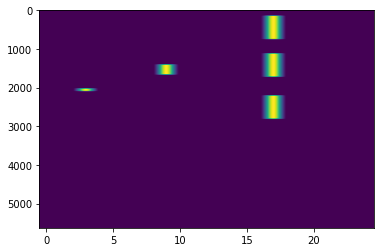

In [47]:
plt.imshow(matrix, aspect="auto")

In [26]:
model = Cnn14_DecisionLevelAtt(sample_rate=16000,
        window_size=1024,
        hop_size=256,
        mel_bins=64,
        fmin=50,
        fmax=8000,
        classes_num=25,
        training=False,
        require_prep=True,
        is_spec_augmenter=False,
        mixup_lambda=None,)
x = torch.tensor(wave[:288000]).unsqueeze(0)
y = model(x)

feature_map:torch.Size([1, 2048, 35, 2])
feature_map: mean-dim3torch.Size([1, 2048, 35])
pool1d_map: mean-dim3torch.Size([1, 2048, 35])


In [28]:
y["clipwise_output"].shape

torch.Size([1, 25])

In [39]:
train_tp[train_tp["count"] == 5]

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max,t_diff,f_diff,count
915,c12e0a62b,9,1,14.9653,1125.00,17.7707,5250.0,2.8054,4125.00,5
916,c12e0a62b,17,1,1.5467,1312.50,8.0000,3937.5,6.4533,2625.00,5
917,c12e0a62b,17,1,11.9200,1312.50,18.3733,3937.5,6.4533,2625.00,5
918,c12e0a62b,3,1,21.5680,1031.25,22.3093,2812.5,0.7413,1781.25,5
919,c12e0a62b,17,1,23.4880,1312.50,29.9413,3937.5,6.4533,2625.00,5
